In [1]:
import syft as sy
import copy
import torch #幹你娘 要裝 1.4.0版喔 因為cuda 10.0.1版的
import torch.nn as nn
from torchvision import datasets ,models,transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


/home/leo6532/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/leo6532/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/leo6532/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/leo6532/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:5

# 使用GPU訓練模型

In [2]:
#Determine if there is a GPU
train_on_gpu = torch.cuda.is_available()
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
PATH_train="./train"
PATH_val="./val"
PATH_test="./test"

In [4]:
TRAIN =Path(PATH_train)
VALID = Path(PATH_val)
TEST=Path(PATH_test)
print(TRAIN)
print(VALID)
print(TEST)

train
val
test


In [5]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32
# learning rate
LR = 0.001

In [6]:
# convert data to a normalized torch.FloatTensor
train_transforms = transforms.Compose([transforms.Resize((50,50)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize((50,50)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((50,50)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

In [7]:
# choose the training and test datasets
train_data = datasets.ImageFolder(TRAIN, transform=train_transforms)
valid_data = datasets.ImageFolder(VALID,transform=valid_transforms)
test_data = datasets.ImageFolder(TEST, transform=test_transforms)


# 切割資料方法1
## 用random_split 去切割

In [8]:
dataset1_size = int(0.8*len(train_data)) #總資料80%
dataset2_size = len(train_data) - dataset1_size #剩餘的20%
#把資料切割成80:20比例
dataset1, dataset2 = torch.utils.data.random_split(train_data, [dataset1_size, dataset2_size])
#bob使用總數據的80%
bob_train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size, num_workers=num_workers,shuffle=True)

In [9]:
print(train_data.class_to_idx)
print(valid_data.class_to_idx)
print(test_data.class_to_idx)

{'sick': 0, 'unsick': 1}
{'sick': 0, 'unsick': 1}
{'sick': 0, 'unsick': 1}


In [10]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,  num_workers=num_workers,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,  num_workers=num_workers)

In [11]:
images,labels=next(iter(train_loader))
images.shape,labels.shape

(torch.Size([32, 3, 50, 50]), torch.Size([32]))

# 肺癌model框架

In [12]:
# Create CNN Model
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=0) #output_shape=(16,220,220) 48
        #(224-5+1)/1 #(weigh-kernel+1)/stride 無條件進位
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) #output_shape=(16,110,110) #(220/2) 16 24 24
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0) #output_shape=(32,106,106) 20 20
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=1) #output_shape=(32,53,53) 10 10
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=1, stride=1, padding=0) #output_shape=(16,51,51) 10 10
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=1) #output_shape=(16,25,25) 5 5
        self.cnn4 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=1, stride=1, padding=0) #output_shape=(8,23,23) 5 5
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=2) #output_shape=(8,11,11) 8 5 5
        # Fully connected 1 ,#input_shape=(8*12*12)
        self.fc1 = nn.Linear(8 * 11 * 11, 512) 
        #self.relu5 = nn.ReLU() # activation
        self.fc2 = nn.Linear(512, 2) 
        #self.output = nn.Softmax(dim=1)
        
    
    def forward(self, x):
        out = self.cnn1(x) # Convolution 1
        out = self.relu1(out)
        out = self.maxpool1(out)# Max pool 1
        out = self.cnn2(out) # Convolution 2
        out = self.relu2(out) 
        out = self.maxpool2(out) # Max pool 2
        out = self.cnn3(out) # Convolution 3
        out = self.relu3(out)
        out = self.maxpool3(out) # Max pool 3
        out = self.cnn4(out) # Convolution 4
        out = self.relu4(out)
        out = self.maxpool4(out) # Max pool 4
#         print(out.size())
        out = out.view(-1, 8*11*11) # last CNN faltten con. Linear NN
#     out = out.view(out.size(0), -1)
        out = self.fc1(out) # Linear function (readout)
        out = self.fc2(out)
        #out = self.output(out)

        return out

In [13]:
model = CNN_Model()

In [14]:
from torchsummary import summary
summary(model.cuda(), (3, 50, 50))
#summary(model, (3, 50, 50),device = "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 48, 48]             448
              ReLU-2           [-1, 16, 48, 48]               0
         MaxPool2d-3           [-1, 16, 24, 24]               0
            Conv2d-4           [-1, 32, 22, 22]           4,640
              ReLU-5           [-1, 32, 22, 22]               0
         MaxPool2d-6           [-1, 32, 22, 22]               0
            Conv2d-7           [-1, 16, 22, 22]             528
              ReLU-8           [-1, 16, 22, 22]               0
         MaxPool2d-9           [-1, 16, 22, 22]               0
           Conv2d-10            [-1, 8, 22, 22]             136
             ReLU-11            [-1, 8, 22, 22]               0
        MaxPool2d-12            [-1, 8, 11, 11]               0
           Linear-13                  [-1, 512]         496,128
           Linear-14                   

In [15]:
#from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm

In [16]:
import torch.optim as optim    
optimizer = torch.optim.Adam(model.parameters(), lr=LR) 
criterion = nn.CrossEntropyLoss() 

#TEST MODEL

In [17]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}'.format(test_loss))

    print('Test Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [18]:
use_cuda = torch.cuda.is_available()
model.cuda()
test(test_loader, model, criterion, use_cuda)

Test Loss: 0.683051
Test Accuracy: 82% (1340/1622)


# 虛擬環境執行 model

In [19]:
import copy

In [20]:
hook = sy.TorchHook(torch)
bob = sy.VirtualWorker(hook, id="bob")
alice = sy.VirtualWorker(hook, id="alice")
server = sy.VirtualWorker(hook, id="server")
compute_nodes = [bob, alice]


# 切割資料方法2
## for loop去切割

In [21]:
train_distributed_dataset = []
for batch_idx, (data, target) in enumerate(train_loader):
    bobs_data = data.send(bob)
    bobs_target = target.send(bob)
    train_distributed_dataset.append((bobs_data, bobs_target))

valid_distributed_dataset = []
for batch_idx, (data, target) in enumerate(valid_loader):
    bobs_data = data.send(bob)
    bobs_target = target.send(bob)
    valid_distributed_dataset.append((bobs_data, bobs_target))

# 切割資料方法3
## sy.FederatedDataLoader

In [22]:
federated_train_loader = sy.FederatedDataLoader(train_data.federate((bob, alice)), batch_size=batch_size, shuffle=True)

### get一次就好 第2次會error

In [23]:
bobs_model = CNN_Model().cuda()
bob_optimizer = torch.optim.Adam(bobs_model.parameters(), lr=LR) 
bob_criterion = nn.CrossEntropyLoss()

In [24]:
def update(n_epochs, train_loader, valid_loader, model, optimizer, criterion):
    train_on_gpu = torch.cuda.is_available()
    print(train_on_gpu)
    print(123)
    train_loss_i = []
    valid_loss_i = []


#     n_epochs = 10 #170


    valid_loss_min = np.Inf # track change in validation loss
    model.send(bob)
    
    #train_losses,valid_losses=[],[]
    for epoch in range(1, n_epochs+1):

        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        print('running epoch: {}'.format(epoch))
        train_dataset_size = 0
        valid_dataset_size = 0
        ###################
        # train the model #
        ###################
        model.train()
        
        for data, target in tqdm(train_loader):
            if(data.location != bob):
                break
                
            
            train_dataset_size += len(data)

            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(),  target.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.get().item()*len(data)
            

        for data, target in tqdm(valid_loader):
            
            valid_dataset_size += len(data)
            
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model

            with torch.no_grad():
                output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.get().item()* len(data)

        
        train_loss = train_loss/train_dataset_size
        valid_loss = valid_loss/valid_dataset_size

        # print training/validation statistics 
        print('\tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
             train_loss,  valid_loss))    
        #作圖接收矩陣
        train_loss_i.append(train_loss)
        valid_loss_i.append(valid_loss)
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
            
    model.get()
    #作圖區
    print(train_loss_i) 
    print(valid_loss_i)    

    #圖區    
    plt.plot(range(n_epochs), train_loss_i,'b-', label='Training_loss')
    plt.plot(range(n_epochs), valid_loss_i,'g-', label='validation_loss')
    plt.title('Training & Validation loss')
    plt.xlabel('Number of epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

True
123
running epoch: 1



	Training Loss: 0.405140 	Validation Loss: 0.376522
Validation loss decreased (inf --> 0.376522).  Saving model ...
running epoch: 2



	Training Loss: 0.335743 	Validation Loss: 0.325890
Validation loss decreased (0.376522 --> 0.325890).  Saving model ...
running epoch: 3



	Training Loss: 0.305495 	Validation Loss: 0.311708
Validation loss decreased (0.325890 --> 0.311708).  Saving model ...
running epoch: 4



	Training Loss: 0.282801 	Validation Loss: 0.313903
running epoch: 5



	Training Loss: 0.262438 	Validation Loss: 0.302854
Validation loss decreased (0.311708 --> 0.302854).  Saving model ...
running epoch: 6



	Training Loss: 0.246109 	Validation Loss: 0.308953
running epoch: 7



	Training Loss: 0.232151 	Validation Loss: 0.343352
running epoch: 8



	Training Loss: 0.221100 	Validation Loss: 0.310688
running epoch: 9



	Training Loss: 0.210151 	Validation Loss: 0.312837
running epoch: 10



	Training Loss: 0.202084 	Validation Loss: 0.306382
[0.405139774359879, 0.3357432687962839, 0.30549458457551665, 0.28280071300568094, 0.26243826165200657, 0.24610856256435343, 0.23215051574863427, 0.22110032179043293, 0.2101510124274226, 0.2020841829934078]
[0.37652197213658206, 0.32588956783667106, 0.31170771901158983, 0.31390340566497266, 0.3028538250288967, 0.3089531085058277, 0.34335234554437094, 0.31068775697152434, 0.3128374350029593, 0.30638161892719057]


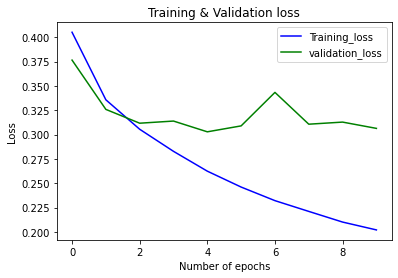

In [25]:
update(10, train_distributed_dataset, valid_distributed_dataset, bobs_model, bob_optimizer, bob_criterion)

In [26]:
bobs_model

CNN_Model(
  (cnn1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (cnn4): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
  (relu4): ReLU()
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=968, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [27]:
test(test_loader, bobs_model, criterion, use_cuda)
# test(test_loader, alices_model, criterion, use_cuda)
# test(test_loader, new_model, criterion, use_cuda)

Test Loss: 0.301029
Test Accuracy: 87% (1420/1622)


# Node gradient send to server

In [28]:
bobS_gradient = bobs_model.copy().send(server)
alices_gardient = alices_model.copy().send(server)

NameError: name 'alices_model' is not defined

In [ ]:
bobS_gradient.get()
alices_gardient.get()

# Use update gradient

In [ ]:
#模型的層數
num_layers = len(list(bobs_model.parameters()))
#模型權重平均運算
new_list = list(map(lambda x,y: x + y, list(bobs_model.parameters()), list(bobs_model.parameters())))
p = list(model.parameters())
print(list(model.parameters()))
print(123)

with torch.no_grad():
    for i in range(num_layers):
        p[i].set_(new_list[i])

print(list(model.parameters()))

In [ ]:
a = [1, 2, 3]
b = [4,5,6]
new_list = map(lambda x,y: x + y, a,b)   
print(list(new_list))